# **European Drug Development**

Team2: Angela Liou

[[Data Source](http://github.com/rfordatascience/tidytuesday/tree/main/data/2023/2023-03-14)]

##Problem Statement

Drug development and regulatory approval are time-consuming and resource-intensive, and stakeholders often face a trade-off between improving efficiency and maintaining patient safety. Building on our M1 proposal, this milestone continues to focus on the European drug development context, with an emphasis on the regulatory review stage and how regulatory conditions shape approval pathways. In M1, our preliminary correlation heatmap suggested that several regulatory flags tend to co-occur rather than appear randomly. I extend that observation by testing whether medicines can be grouped into interpretable “regulatory pathway” segments using key regulatory indicators (e.g., additional monitoring, conditional approval, accelerated assessment, orphan designation, exceptional circumstances).

To keep the analysis closer to a real-world use case, I cluster medicines using regulatory indicators as inputs, and then treat authorization lead time, therapeutic area, and product type (generic vs. biosimilar) as external variables for validation and interpretation. The overarching goal is to support more evidence-based decision-making for both regulators and industry by identifying patterns that could inform review prioritization and resource allocation.


##Data Overview

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import .csv data
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/drugs.csv')
data.head()

,category,medicine_name,therapeutic_area,common_name,active_substance,product_number,patient_safety,authorisation_status,atc_code,additional_monitoring,...,marketing_authorisation_holder_company_name,pharmacotherapeutic_group,date_of_opinion,decision_date,revision_number,condition_indication,species,first_published,revision_date,url
0,human,Adcetris,"Lymphoma, Non-Hodgkin; Hodgkin Disease",brentuximab vedotin,brentuximab vedotin,2455,False,authorised,L01XC12,False,...,Takeda Pharma A/S,Antineoplastic agents,2012-07-19,2022-11-17,34.0,Hodgkin lymphomaAdcetris is indicated for adul...,NaN,2018-07-25T13:58:00Z,2023-03-13T11:52:00Z,https://www.ema.europa.eu/en/medicines/human/E...
1,human,Nityr,Tyrosinemias,nitisinone,nitisinone,4582,False,authorised,A16AX04,False,...,Cycle Pharmaceuticals (Europe) Ltd,"Other alimentary tract and metabolism products,",2018-05-31,2023-03-10,4.0,Treatment of adult and paediatric patients wit...,NaN,2018-07-26T14:20:00Z,2023-03-10T17:29:00Z,https://www.ema.europa.eu/en/medicines/human/E...
2,human,Ebvallo,Lymphoproliferative Disorders,tabelecleucel,tabelecleucel,4577,False,authorised,NaN,True,...,Pierre Fabre Medicament,NaN,2022-10-13,2023-03-09,2.0,Ebvallo is indicated as monotherapy for treatm...,NaN,2022-10-12T16:13:00Z,2023-03-10T13:40:00Z,https://www.ema.europa.eu/en/medicines/human/E...
3,human,Ronapreve,COVID-19 virus infection,"casirivimab, imdevimab","casirivimab, imdevimab",5814,False,authorised,J06BD,True,...,Roche Registration GmbH,"Immune sera and immunoglobulins,",2021-11-11,2023-02-24,3.0,Ronapreve is indicated for:Treatment of COVID-...,NaN,2021-11-12T16:30:00Z,2023-03-10T12:29:00Z,https://www.ema.europa.eu/en/medicines/human/E...
4,human,Cosentyx,"Arthritis, Psoriatic; Psoriasis; Spondylitis...",secukinumab,secukinumab,3729,False,authorised,L04AC10,False,...,Novartis Europharm Limited,Immunosuppressants,2014-11-20,2023-01-26,30.0,Plaque psoriasisCosentyx is indicated for the ...,NaN,2018-06-07T11:59:00Z,2023-03-09T18:53:00Z,https://www.ema.europa.eu/en/medicines/human/E...


In [3]:
# Data overview
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   category                                     1988 non-null   object 
 1   medicine_name                                1988 non-null   object 
 2   therapeutic_area                             1703 non-null   object 
 3   common_name                                  1984 non-null   object 
 4   active_substance                             1987 non-null   object 
 5   product_number                               1988 non-null   int64  
 6   patient_safety                               1988 non-null   bool   
 7   authorisation_status                         1987 non-null   object 
 8   atc_code                                     1960 non-null   object 
 9   additional_monitoring                        1988 non-null   bool   
 10  

In [4]:
print(data.nunique())

category                                          2
medicine_name                                  1976
therapeutic_area                                669
common_name                                    1261
active_substance                               1345
product_number                                 1932
patient_safety                                    2
authorisation_status                              3
atc_code                                       1074
additional_monitoring                             2
generic                                           2
biosimilar                                        2
conditional_approval                              2
exceptional_circumstances                         2
accelerated_assessment                            2
orphan_medicine                                   2
marketing_authorisation_date                   1127
date_of_refusal_of_marketing_authorisation       67
marketing_authorisation_holder_company_name     615
pharmacother

##EDA & Preprocessing

In M1, our EDA highlighted two practical issues that directly shaped this milestone’s analysis. First, the regulatory flags are highly sparse (most values are 0) but not independent. In other words, several indicators show noticeable co-occurrence patterns. This suggested that medicines may form a small number of regulatory “pathway archetypes,” and also implied that we should use distance and clustering choices that are appropriate for sparse binary features. Second, a closer look at the time-related fields showed that the dataset contains multiple dates that reflect different stages and possible updates in the regulatory process, meaning a single “decision time” definition can be ambiguous without careful interpretation.

Based on these findings, I made two key updates in M2. I replaced the earlier “Decision Making Time (days)” with two clearer outcome variables, "Authorized Time (days)" and "Refused Time (days)", defined as the gap between the CHMP opinion date and the European Commission’s authorization/refusal date, respectively. This refinement aligns the timing metric with the post-opinion decision window and helps avoid mixing in dates that may reflect later revisions. I also improved the binary-flag correlation heatmap by using a symmetric color scale centered at zero so that positive and negative associations are visually comparable. Together, these EDA and preprocessing updates motivate my approach in this milestone: I cluster medicines using regulatory indicators as inputs and then use the refined lead-time measures and product type (generic vs. biosimilar) as external variables for validation and interpretation.

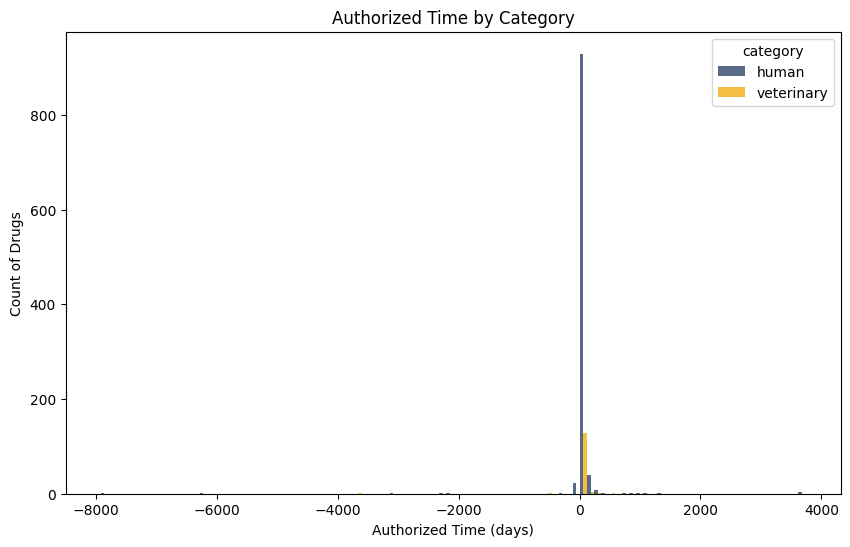

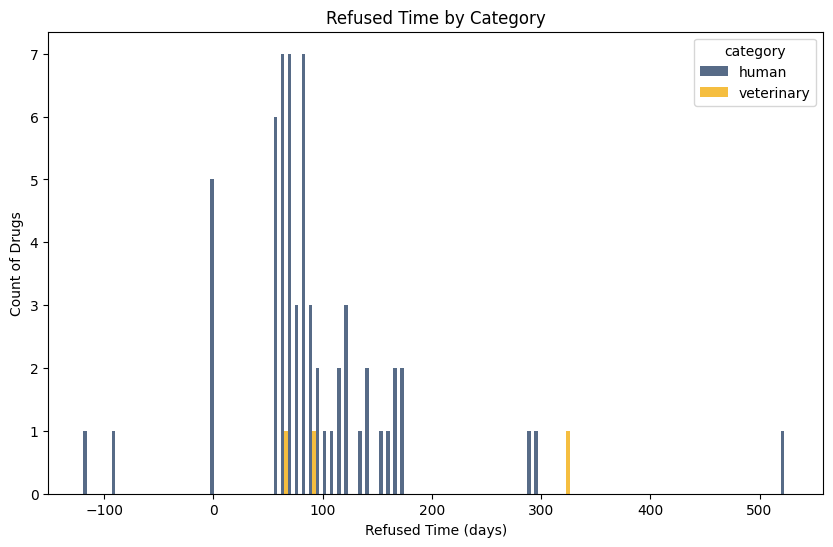

In [5]:
# Calculate "CHMP opinion → EC decision lead time" in days
import matplotlib.pyplot as plt
import seaborn as sns

# Convert dates to datetime
data['date_of_opinion'] = pd.to_datetime(data['date_of_opinion'], errors='coerce')
data['marketing_authorisation_date'] = pd.to_datetime(data['marketing_authorisation_date'], errors='coerce')
data['date_of_refusal_of_marketing_authorisation'] = pd.to_datetime(data['date_of_refusal_of_marketing_authorisation'], errors='coerce')

# Calculate time difference in days
data['authorized_time'] = (data['marketing_authorisation_date'] - data['date_of_opinion']).dt.days
data['refused_time'] = (data['date_of_refusal_of_marketing_authorisation'] - data['date_of_opinion']).dt.days

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='authorized_time', hue='category', bins=100, palette={'human': '#1f3a5f', 'veterinary': '#f2a900'}, multiple='dodge', edgecolor='none')
plt.title('Authorized Time by Category')
plt.xlabel('Authorized Time (days)')
plt.ylabel('Count of Drugs')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='refused_time', hue='category', bins=100, palette={'human': '#1f3a5f', 'veterinary': '#f2a900'}, multiple='dodge', edgecolor='none')
plt.title('Refused Time by Category')
plt.xlabel('Refused Time (days)')
plt.ylabel('Count of Drugs')
plt.show()

In [6]:
print(data[['authorized_time', 'refused_time']].describe())

       authorized_time  refused_time
count      1151.000000     64.000000
mean         65.283232     96.671875
std         415.875568     89.656851
min       -7920.000000   -119.000000
25%          56.000000     63.000000
50%          62.000000     81.500000
75%          74.000000    116.750000
max        3737.000000    526.000000


**Why I revised the timing metric:**

After revisiting the dataset definitions, I realized the file contains multiple date columns that correspond to different regulatory steps and may also be updated over time. Using a single “decision date” therefore risks mixing different process stages. To align the analysis with a clearer and more decision-relevant interpretation, I revised the timing metric into two separate outcomes.

**What I changed and how I computed it:**

I define "Authorized Time (days)" as the time from CHMP opinion to European Commission marketing authorization (i.e., marketing_authorisation_date − date_of_opinion). Similarly, I define "Refused Time (days)" as the time from CHMP opinion to European Commission refusal (i.e., date_of_refusal_of_marketing_authorisation − date_of_opinion). I compute these metrics separately because authorized and refused cases follow different endpoints in the dataset.

**What I observed and why it matters:**

Plotting Authorized Time and Refused Time by category (human vs. veterinary) provides a quick check of whether timelines differ systematically across product types and helps validate that our revised metrics behave sensibly. Authorized cases show a clearer central range with some outliers, while refused cases are fewer and more variable, so comparisons for refused timelines should be interpreted cautiously. This EDA step motivates treating lead time as an external validation outcome in later analyses (e.g., cluster profiling) and reinforces the need to handle outliers and small-sample subgroups carefully.


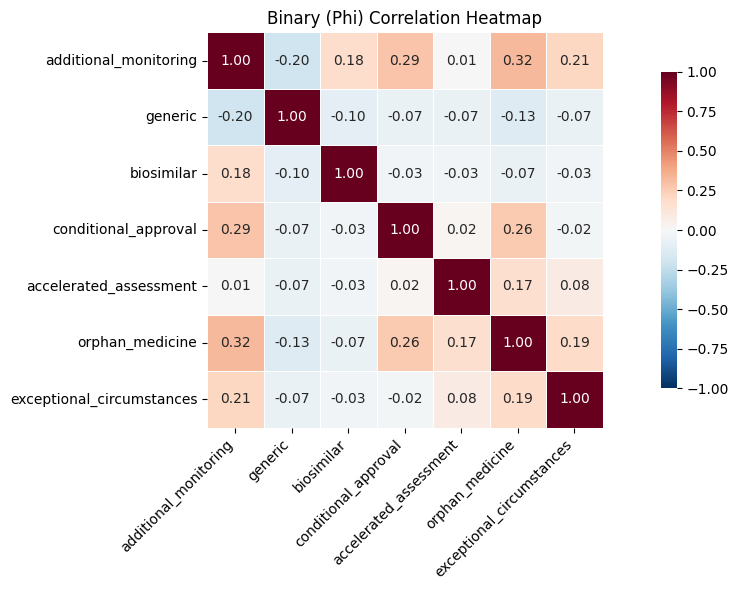

In [7]:
# Binary variables correlation heatmap
import numpy as np
from scipy.stats import chi2_contingency

binary_vars = ['additional_monitoring','generic','biosimilar','conditional_approval', 'accelerated_assessment', 'orphan_medicine', 'exceptional_circumstances']
data_binary = data[binary_vars].apply(pd.to_numeric, errors='coerce').dropna()

# Phi correlation matrix
phi_corr = data_binary.corr(method='pearson')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(phi_corr, annot=True, fmt='.2f', center=0, cmap='RdBu_r', vmin=-1, vmax=1,square=True,
            cbar_kws={'shrink': 0.8}, linewidths=0.5)
plt.title('Binary (Phi) Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Insights:**
addtional_monitoring seems to be corelated with other regulatory features.

**Inspired Question:**
Does additional monitoring act as a central regulatory feature around which other special designations (e.g., orphan status, conditional approval, exceptional circumstances) tend to co-occur, forming a distinct subgroup of medicines?

If there is no tendancy of co-occurance, we would be surprised because additional monitor is supposed to be a means to make sure regulated drugs are used in a safe way.

**M2 update:**
In M2, I refined the correlation heatmap visualization to make positive vs. negative associations easier to interpret. Specifically, I used a symmetric color scale centered at 0 so that the same magnitude (e.g., +0.2 and −0.2) is shown with equal visual intensity in opposite directions. This adjustment reduces visual bias from the color mapping and makes the co-occurrence patterns (and lack of co-occurrence) more transparent.

In [8]:
# Top 50 active substances
df_unique_medicine = (
    data[['medicine_name', 'active_substance']]
    .dropna(subset=['medicine_name', 'active_substance'])
    .drop_duplicates(subset=['medicine_name'])
)

top_50_active_substances = (
    df_unique_medicine['active_substance']
    .value_counts()
    .head(50)
)

print(top_50_active_substances)

active_substance
meloxicam                                    18
adalimumab                                   16
olanzapine                                   12
insulin human                                12
bevacizumab                                  12
pegfilgrastim                                12
pregabalin                                   10
pioglitazone hydrochloride                   10
filgrastim                                    9
telmisartan                                   9
clopidogrel                                   9
desloratadine                                 9
levetiracetam                                 9
rituximab                                     8
teriparatide                                  8
rivastigmine                                  8
ibandronic acid                               8
memantine hydrochloride                       8
docetaxel                                     8
clopidogrel (as hydrochloride)                8
trastuzumab            

**Insights:**
Among top active substances, meloxicam and olanzapine are mature generic drug, adalimumab, bevacizumab, and pegfilgrastim are biosimilar drug that compete with each other. Insulin human is a stable drug for diabete. This pattern suggests that repeated appearances and regulatory intensity are shaped by therapeutic area rather than by unique characteristics of individual medicines.

**Inspired Question:**
Are medicines more similar to each other in regulatory profile when they share the same active substance or when they belong to the same therapeutic domain?

If drugs sharing the same active substance are not in the same cluster, while medicines within the same therapeutic domain exhibit high similarity, this would indicate the dominant role of therapeutic domain over molecular identity.

In [9]:
# Top 20 marketing authorisation holder company names
top_20_companies = data['marketing_authorisation_holder_company_name'].value_counts().head(20)
print(top_20_companies)

marketing_authorisation_holder_company_name
Accord Healthcare S.L.U.                   58
Novartis Europharm Limited                 58
Pfizer Europe MA EEIG                      43
Zoetis Belgium SA                          40
AstraZeneca AB                             36
Boehringer Ingelheim Vetmedica GmbH        36
Teva B.V.                                  32
Merck Sharp & Dohme B.V.                   32
Intervet International BV                  31
Eli Lilly Nederland B.V.                   30
Novo Nordisk A/S                           28
Bristol-Myers Squibb Pharma EEIG           26
Mylan Pharmaceuticals Limited              26
Roche Registration GmbH                    26
Janssen-Cilag International NV             23
Boehringer Ingelheim International GmbH    22
Gilead Sciences Ireland UC                 21
Sanofi Winthrop Industrie                  19
Teva Pharma B.V.                           18
Sandoz GmbH                                18
Name: count, dtype: int64


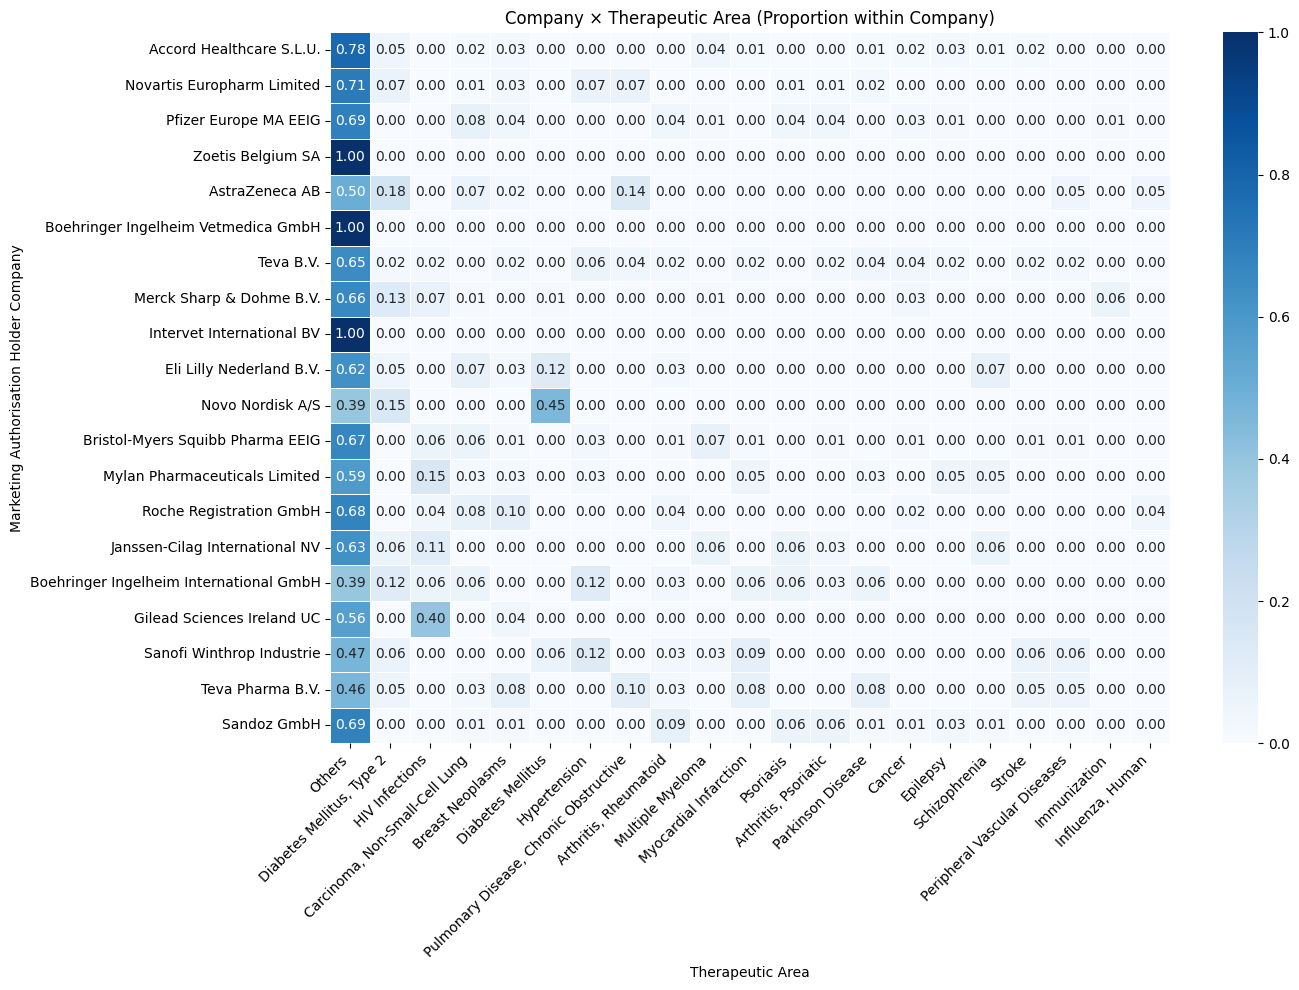

In [10]:
# Companies vs Therapeutic Areas Heatmap
# Top 20 companies
top_20_companies = data['marketing_authorisation_holder_company_name'].value_counts().head(20).index.tolist()

# Clean therapeutic_area
exploded_areas = data['therapeutic_area'].str.split(';').explode().str.strip()
top_20_areas = exploded_areas.value_counts().head(20).index.tolist()
exploded_areas = exploded_areas.apply(lambda x: x if x in top_20_areas else 'Others')

# Create analysis dataframe
analysis_df = data.copy().loc[exploded_areas.index]
analysis_df['therapeutic_area_clean'] = exploded_areas.values
analysis_df = analysis_df[analysis_df['marketing_authorisation_holder_company_name'].isin(top_20_companies)]

# Function to create heatmap for a category
heatmap_counts = (
    analysis_df
    .groupby(['marketing_authorisation_holder_company_name', 'therapeutic_area_clean'])
    .size()
    .unstack(fill_value=0)
)

area_order = (
    analysis_df['therapeutic_area_clean']
    .value_counts()
    .index
    .tolist()
)
heatmap_counts = heatmap_counts.reindex(columns=area_order, fill_value=0)
heatmap_counts = heatmap_counts.reindex(index=top_20_companies)

heatmap_prop = heatmap_counts.div(heatmap_counts.sum(axis=1).replace(0, pd.NA), axis=0).fillna(0)

# plot
plt.figure(figsize=(14, 10))
ax = sns.heatmap(
    heatmap_prop,
    cmap='Blues',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    linecolor='white'
)

plt.title('Company × Therapeutic Area (Proportion within Company)')
plt.xlabel('Therapeutic Area')
plt.ylabel('Marketing Authorisation Holder Company')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Insights:**
Some primary companies focus on primary therapeutic area. For instance, Novo Nordisk A/S focuses onDiabetes Mellitus, Gilead Science Ireland UC focuses on HIV Infections, and AZ focuses on Diabetes and pulmonary disease. In contrast, companies like Boehringer Ingelheim Vetmedica GmbH and Sanofi distribute R&D resources to various areas.

In [11]:
# Check for drugs where both generic=1 and biosimilar=1
both = data[(data['generic'] == 1) & (data['biosimilar'] == 1)]
print(f"Number of drugs where both generic=1 and biosimilar=1: {len(both)}")
if len(both) > 0:
    print("Examples:")
    print(both[['medicine_name', 'active_substance', 'marketing_authorisation_holder_company_name']].head())
else:
    print("No such drugs found.")

Number of drugs where both generic=1 and biosimilar=1: 0
No such drugs found.


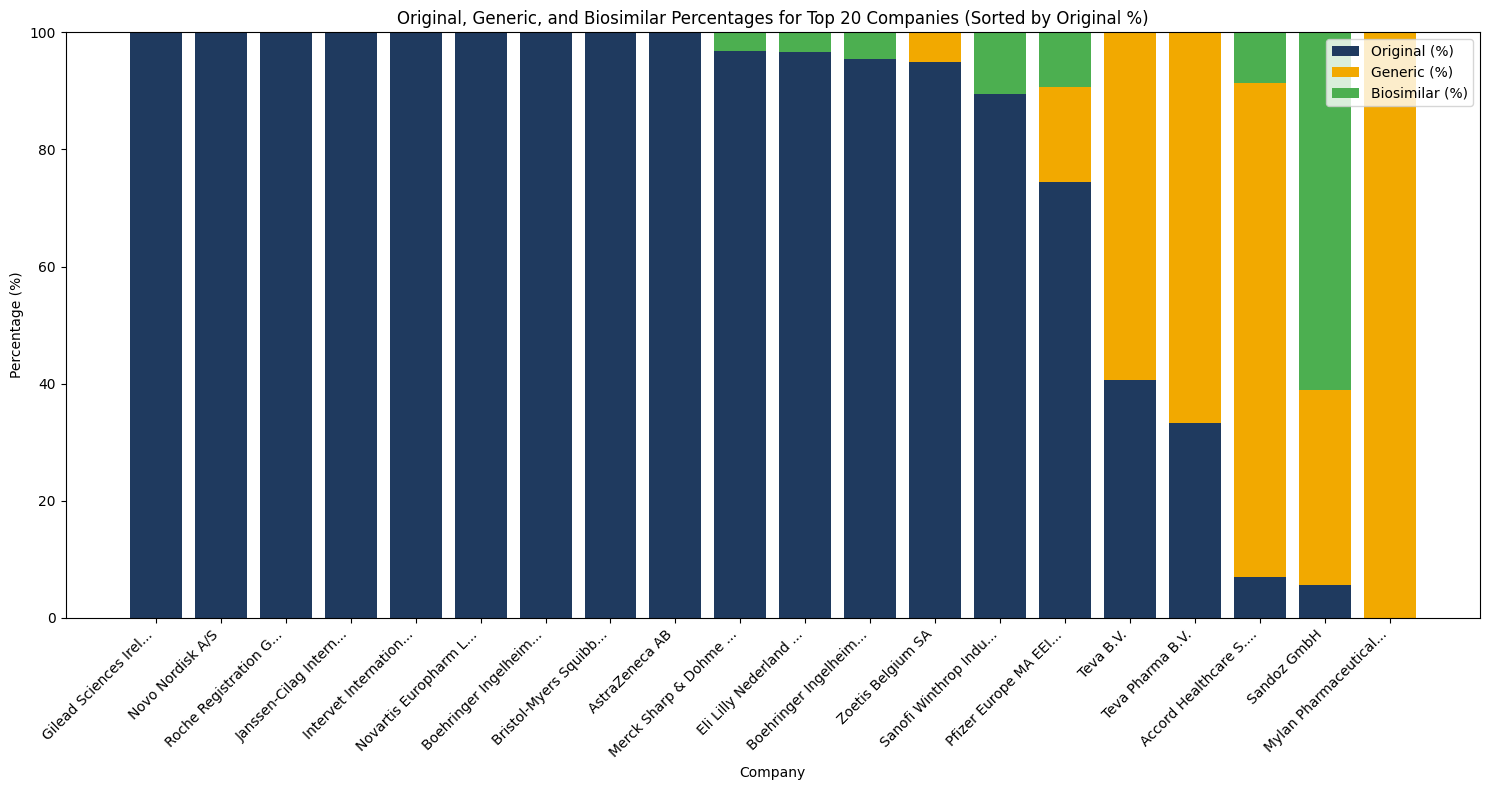

In [12]:
# Top 20 companies
top_20_companies = data['marketing_authorisation_holder_company_name'].value_counts().head(20).index.tolist()

# Calculate percentages
original_percent = []
generic_percent = []
biosimilar_percent = []
companies_list = []
for company in top_20_companies:
    company_data = data[data['marketing_authorisation_holder_company_name'] == company]
    total = len(company_data)
    if total > 0:
        orig_pct = ((company_data['generic'] == 0) & (company_data['biosimilar'] == 0)).sum() / total * 100
        gen_pct = (company_data['generic'] == 1).sum() / total * 100
        bio_pct = (company_data['biosimilar'] == 1).sum() / total * 100
    else:
        orig_pct = 0
        gen_pct = 0
        bio_pct = 0
    original_percent.append(orig_pct)
    generic_percent.append(gen_pct)
    biosimilar_percent.append(bio_pct)
    companies_list.append(company)

# Sort by descending original percentage
sorted_indices = np.argsort(original_percent)[::-1]
original_percent = [original_percent[i] for i in sorted_indices]
generic_percent = [generic_percent[i] for i in sorted_indices]
biosimilar_percent = [biosimilar_percent[i] for i in sorted_indices]
companies_sorted = [companies_list[i] for i in sorted_indices]

# Plot stacked bar chart
x = np.arange(len(companies_sorted))

fig, ax = plt.subplots(figsize=(15, 8))
bars1 = ax.bar(x, original_percent, label='Original (%)', color='#1f3a5f')
bars2 = ax.bar(x, generic_percent, bottom=original_percent, label='Generic (%)', color='#f2a900')
bars3 = ax.bar(x, biosimilar_percent, bottom=np.array(original_percent) + np.array(generic_percent), label='Biosimilar (%)', color='#4CAF50')

ax.set_xlabel('Company')
ax.set_ylabel('Percentage (%)')
ax.set_title('Original, Generic, and Biosimilar Percentages for Top 20 Companies (Sorted by Original %)')
ax.set_xticks(x)
ax.set_xticklabels([c[:20] + '...' if len(c) > 20 else c for c in companies_sorted], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

**Insights:**
Most of top companies develop original drugs, while only 3 of them focus on generic medicines. It might be useful to analyze and compare performce (e.g., authorisation rate, profit) of companies leveraging different R&D strategies.

**Inspired Question:**
Do companies cluster primarily by shared therapeutic focus (e.g., diabetes-focused) or by development model (e.g., generic/biosimilar-heavy)?

In [13]:
# Check authorisation_status values
print("Value counts:")
print(data['authorisation_status'].value_counts())
print("\nUnique values:")
print(data['authorisation_status'].unique())

Value counts:
authorisation_status
authorised    1573
withdrawn      357
refused         57
Name: count, dtype: int64

Unique values:
['authorised' 'withdrawn' 'refused' nan]


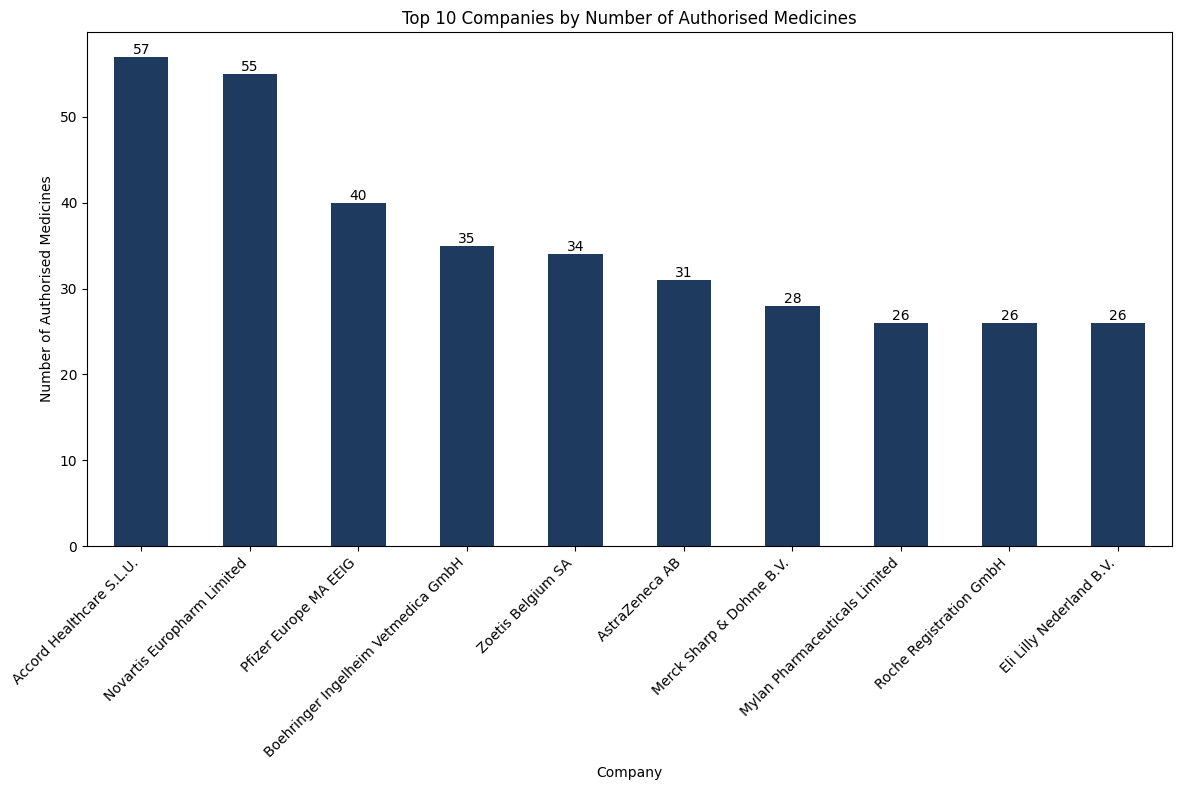

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = data.copy()
df = df[
    [
        'marketing_authorisation_holder_company_name',
        'authorisation_status',
        'product_number'
    ]
].dropna(subset=['marketing_authorisation_holder_company_name', 'authorisation_status', 'product_number'])

df_auth = df[df['authorisation_status'] == 'authorised']

# Drop duplicates
df_auth_unique = df_auth.drop_duplicates(
    subset=['marketing_authorisation_holder_company_name', 'product_number']
)

# Claculate authorisation counts
authorised_counts = (
    df_auth_unique
    .groupby('marketing_authorisation_holder_company_name')
    .size()
    .sort_values(ascending=False)
)

top_10 = authorised_counts.head(10)

# Bar Chart
plt.figure(figsize=(12, 8))
ax = top_10.plot(kind='bar', color='#1f3a5f')
plt.title('Top 10 Companies by Number of Authorised Medicines')
plt.xlabel('Company')
plt.ylabel('Number of Authorised Medicines')
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.show()

**Insights:**
Accord Healthcare S.L.U, which mainly developed generic drugs, got the most authorisation within the time range in the dataset. Novartis Europharm Limited, who 100% developed origin drugs, got the 2nd most authorisation. This may indicate that original, biosimilar, and generic features do not impact whether the medicine would be approved.

**Inspired Question:**
Do companies with different development strategies (originator-focused, generic-focused, or biosimilar-focused) achieve similar authorization outcomes through distinct regulatory pathways?

A high degree of overlap in regulatory profiles and decision-time distributions between generic- and originator-focused companies would suggest that strategic differences are of limited importance.

##Hierarchical Clustering

### **Distance matrix (jaccard) + Linkage (average)**

/tmp/ipython-input-3949483276.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X = X.replace({True: 1, False: 0})
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Rows used for clustering: 1988
Feature matrix shape: (1988, 5)


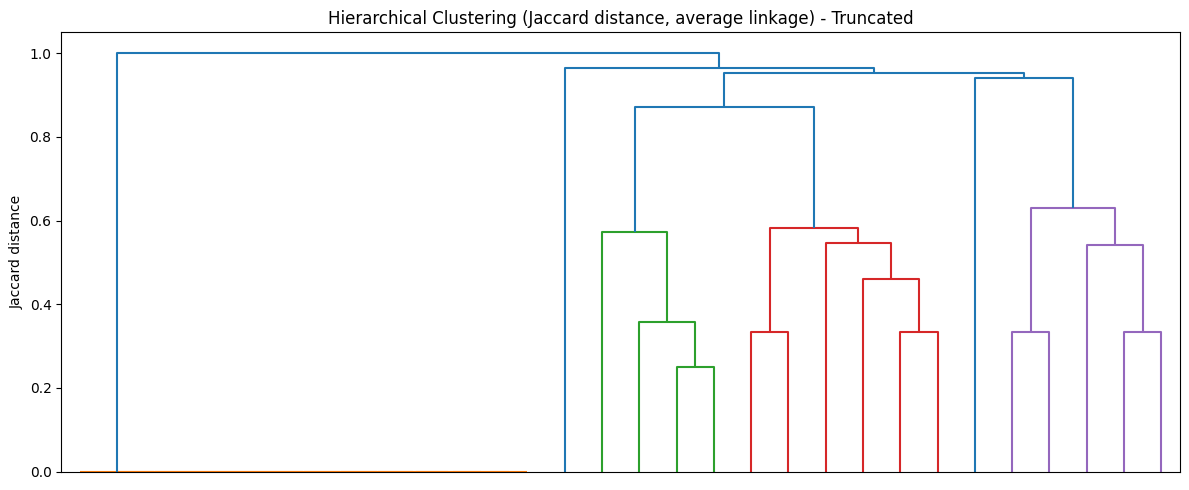

In [15]:
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# Choose features (binary flags)
features = [
    'additional_monitoring',
    'conditional_approval',
    'accelerated_assessment',
    'orphan_medicine',
    'exceptional_circumstances'
]


# Prepare a clean 0/1 matrix X
X = data[features].copy()

# Convert booleans to 0/1
X = X.replace({True: 1, False: 0})

# Convert anything else to numeric; invalid -> NaN
X = X.apply(pd.to_numeric, errors='coerce')

X = X.dropna()

print("Rows used for clustering:", X.shape[0])
print("Feature matrix shape:", X.shape)

# Compute Jaccard distance matrix
D = pairwise_distances(X.to_numpy(), metric='jaccard')

# Convert square distance matrix to condensed vector
condensed_D = D[np.triu_indices_from(D, k=1)]

Z = linkage(condensed_D, method='average')


# Visualize dendrogram
plt.figure(figsize=(12, 5))
dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True,
    no_labels=True
)
plt.title("Hierarchical Clustering (Jaccard distance, average linkage) - Truncated")
plt.ylabel("Jaccard distance")
plt.tight_layout()
plt.show()


The resulting dendrogram suggests a clear high-level structure: a large baseline population of medicines with few or no special designations, alongside smaller branches representing rarer regulatory patterns (e.g., monitoring-heavy, accelerated/exceptional, or conditional approval–related groups).

#### **k = 4**

In [16]:
k = 4
clusters_4 = fcluster(Z, t=k, criterion='maxclust')

# Attach cluster labels back to the original rows used
clustered_4_df = data.loc[X.index].copy()
clustered_4_df['clusters_4'] = clusters_4

clustered_4_df['clusters_4'].value_counts()

,count
clusters_4,
1,1500
3,444
4,40
2,4


In [17]:
profile = clustered_4_df.groupby('clusters_4')[features].mean()
display(profile)

,additional_monitoring,conditional_approval,accelerated_assessment,orphan_medicine,exceptional_circumstances
clusters_4,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.864865,0.094595,0.038288,0.362613,0.078829
4,0.075000,0.050000,0.775000,0.025000,0.325000


##### **Cluster Flag Profiles**

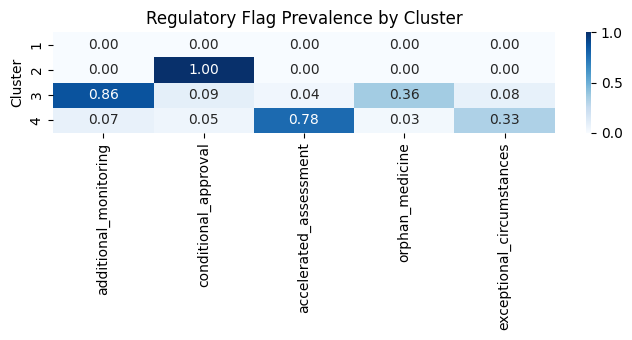

In [18]:
flag_profile = clustered_4_df.groupby('clusters_4')[features].mean()

plt.figure(figsize=(7, 3.5))
sns.heatmap(flag_profile, annot=True, fmt=".2f", cmap="Blues")
plt.title("Regulatory Flag Prevalence by Cluster")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


The clusters form clear and interpretable regulatory “pathway archetypes.” Cluster 1 is a baseline group with virtually no special regulatory flags, suggesting most medicines follow a standard review pathway. Cluster 2 is a very small but highly specific subgroup dominated by conditional approval. Cluster 3 is characterized by a high prevalence of additional monitoring and a meaningful share of orphan medicines, indicating a pathway context where ongoing monitoring and specialized populations are more common. Cluster 4 is defined by accelerated assessment along with a notable presence of exceptional circumstances, consistent with expedited or non-standard review conditions. Overall, the flag profiles suggest the clustering is capturing meaningful regulatory structures rather than random combinations.

#### **k = 5**

In [19]:
k = 5
clusters_5 = fcluster(Z, t=k, criterion='maxclust')

clustered_5_df = data.loc[X.index].copy()
clustered_5_df['cluster_5'] = clusters_5

clustered_5_df['cluster_5'].value_counts()

,count
cluster_5,
1,1500
3,444
5,31
4,9
2,4


In [20]:
profile = clustered_5_df.groupby('cluster_5')[features].mean()
display(profile)

,additional_monitoring,conditional_approval,accelerated_assessment,orphan_medicine,exceptional_circumstances
cluster_5,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.864865,0.094595,0.038288,0.362613,0.078829
4,0.000000,0.000000,0.000000,0.000000,1.000000
5,0.096774,0.064516,1.000000,0.032258,0.129032


#### **k = 6**

In [21]:
k = 6
clusters_6 = fcluster(Z, t=k, criterion='maxclust')

clustered_6_df = data.loc[X.index].copy()
clustered_6_df['cluster_6'] = clusters_6

clustered_6_df['cluster_6'].value_counts()

,count
cluster_6,
1,1500
4,377
3,67
6,31
5,9
2,4


In [22]:
profile = clustered_6_df.groupby('cluster_6')[features].mean()
display(profile)

,additional_monitoring,conditional_approval,accelerated_assessment,orphan_medicine,exceptional_circumstances
cluster_6,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.104478,0.000000,0.253731,1.000000,0.014925
4,1.000000,0.111406,0.000000,0.249337,0.090186
5,0.000000,0.000000,0.000000,0.000000,1.000000
6,0.096774,0.064516,1.000000,0.032258,0.129032


#### **k = 7**

In [23]:
k = 7
clusters_7 = fcluster(Z, t=k, criterion='maxclust')

clustered_7_df = data.loc[X.index].copy()
clustered_7_df['cluster_7'] = clusters_7

clustered_7_df['cluster_7'].value_counts()

,count
cluster_7,
1,1500
4,377
3,67
7,28
5,9
2,4
6,3


In [24]:
profile = clustered_7_df.groupby('cluster_7')[features].mean()
display(profile)

,additional_monitoring,conditional_approval,accelerated_assessment,orphan_medicine,exceptional_circumstances
cluster_7,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.000000,0.000000,0.000000
3,0.104478,0.000000,0.253731,1.000000,0.014925
4,1.000000,0.111406,0.000000,0.249337,0.090186
5,0.000000,0.000000,0.000000,0.000000,1.000000
6,1.000000,0.666667,1.000000,0.000000,0.000000
7,0.000000,0.000000,1.000000,0.035714,0.142857


Across all k (4–7), a dominant baseline cluster consistently appeared, reflecting that most medicines have no (or very few) regulatory flags, while additional clusters captured rarer pathway patterns that became increasingly small as k increased. I selected k=4 because it provided the most interpretable set of pathway archetypes without over-fragmenting the data. In contrast, k≥5 mainly split the rare flags into tiny clusters, which reduced the stability and usefulness of comparisons such as lead-time distributions and generic/biosimilar profiling.

### **Distance matrix (jaccard) + Linkage (complete)**

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/pairwise.py:2466: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


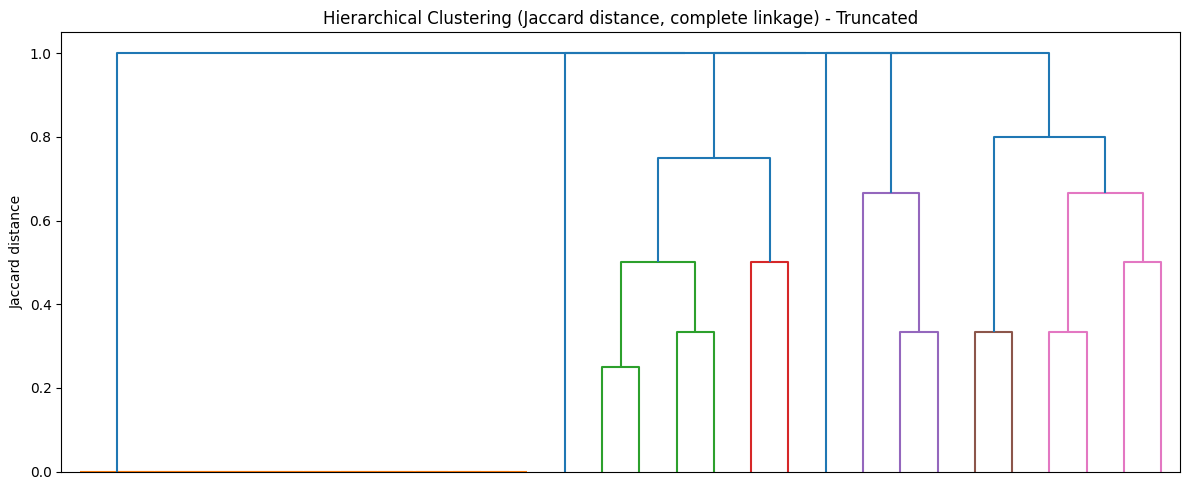

In [25]:
D_jac = pairwise_distances(X.to_numpy(), metric='jaccard')
condensed_jac = D_jac[np.triu_indices_from(D_jac, k=1)]
Z_complete = linkage(condensed_jac, method='complete')

plt.figure(figsize=(12, 5))
dendrogram(
    Z_complete,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True,
    no_labels=True
)
plt.title("Hierarchical Clustering (Jaccard distance, complete linkage) - Truncated")
plt.ylabel("Jaccard distance")
plt.tight_layout()
plt.show()


#### **k = 4**

In [26]:
k = 4
clusters_complete = fcluster(Z_complete, t=k, criterion='maxclust')

clustered_complete = data.loc[X.index].copy()
clustered_complete['cluster_complete'] = clusters_complete

print(clustered_complete['cluster_complete'].value_counts().sort_index())

# Cluster profile (flag prevalence)
profile_complete = clustered_complete.groupby('cluster_complete')[features].mean()
display(profile_complete)

cluster_complete
1    1988
Name: count, dtype: int64


,additional_monitoring,conditional_approval,accelerated_assessment,orphan_medicine,exceptional_circumstances
cluster_complete,,,,,
1,0.194668,0.024145,0.024145,0.081489,0.024145


In theory, complete linkage can produce compact clusters by defining inter-cluster distance as the maximum pairwise distance. However, in this dataset, when I attempted to cut the tree into k=4 clusters, the resulting assignment collapsed into effectively one cluster, making clusters less usable for profiling.

### **Distance matrix (hamming) + Linkage (average)**

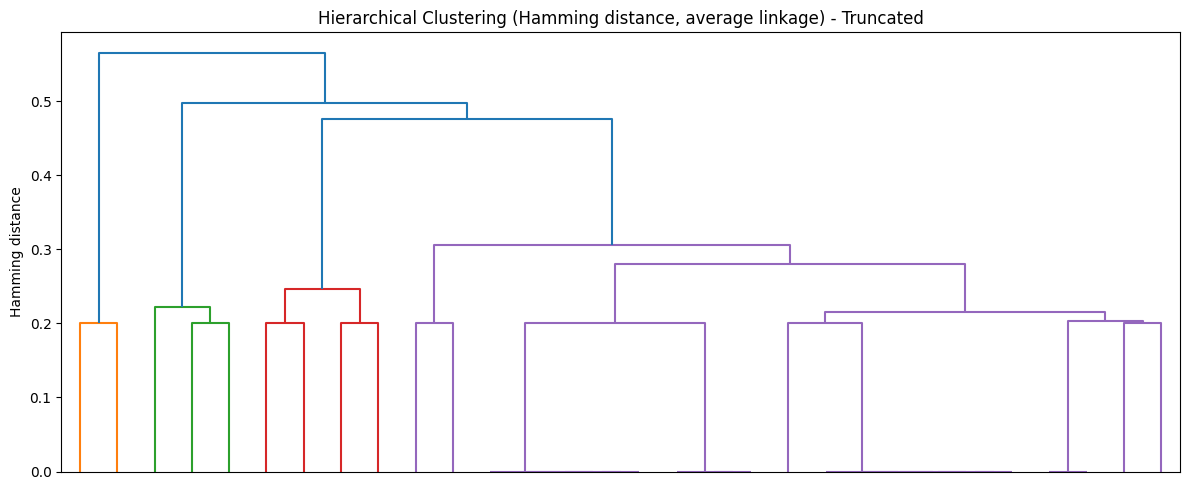

In [27]:
# Compute HAMMING distance matrix
# Hamming distance = fraction of positions that differ
D_ham = pairwise_distances(X, metric='hamming')

condensed_ham = D_ham[np.triu_indices_from(D_ham, k=1)]
Z_ham = linkage(condensed_ham, method='average')

plt.figure(figsize=(12, 5))
dendrogram(
    Z_ham,
    truncate_mode='lastp',
    p=30,
    show_leaf_counts=True,
    no_labels=True
)
plt.title("Hierarchical Clustering (Hamming distance, average linkage) - Truncated")
plt.ylabel("Hamming distance")
plt.tight_layout()
plt.show()

#### **k = 4**

In [28]:
k = 4
clusters_ham = fcluster(Z_ham, t=k, criterion='maxclust')
clustered_ham = data.loc[X.index].copy()
clustered_ham['cluster_ham'] = clusters_ham

print(clustered_ham['cluster_ham'].value_counts().sort_index())

# Cluster profile (flag prevalence)
profile_ham = clustered_ham.groupby('cluster_ham')[features].mean()
display(profile_ham)

cluster_ham
1      19
2      44
3      18
4    1907
Name: count, dtype: int64


,additional_monitoring,conditional_approval,accelerated_assessment,orphan_medicine,exceptional_circumstances
cluster_ham,,,,,
1,1.000000,0.000000,0.052632,1.000000,1.000000
2,1.000000,1.000000,0.045455,0.590909,0.000000
3,0.388889,0.000000,1.000000,0.944444,0.055556
4,0.166230,0.002098,0.014158,0.052438,0.014683


Hamming distance counts mismatches across all five binary positions, which implicitly gives substantial weight to shared zeros as well as shared ones. In sparse-flag settings, this can be problematic because many medicines will appear similar simply because they share the absence of rare flags.

### **Cluster Profiling & Validation**

#### **Authorization Lead Time**

In [29]:
# test columns
required_cols = ['clusters_4', 'therapeutic_area', 'active_substance','authorized_time', 'generic', 'biosimilar']
missing = [c for c in required_cols if c not in clustered_4_df.columns]
print("Missing columns:", missing)

Missing columns: []


In [30]:
df_time = clustered_4_df[['clusters_4', 'authorized_time']].copy()

df_time = df_time.dropna(subset=['authorized_time'])
df_time = df_time[df_time['authorized_time'] >= 0]

print("Rows used for lead time plots:", df_time.shape[0])
df_time.groupby('clusters_4')['authorized_time'].describe()


Rows used for lead time plots: 1141


,count,mean,std,min,25%,50%,75%,max
clusters_4,,,,,,,,
1,751.0,89.595206,206.302293,0.0,57.00,63.0,82.00,3737.0
2,2.0,73.500000,24.748737,56.0,64.75,73.5,82.25,91.0
3,365.0,77.493151,201.358786,0.0,56.00,60.0,64.00,3736.0
4,23.0,243.565217,768.122672,29.0,46.00,56.0,62.50,3707.0


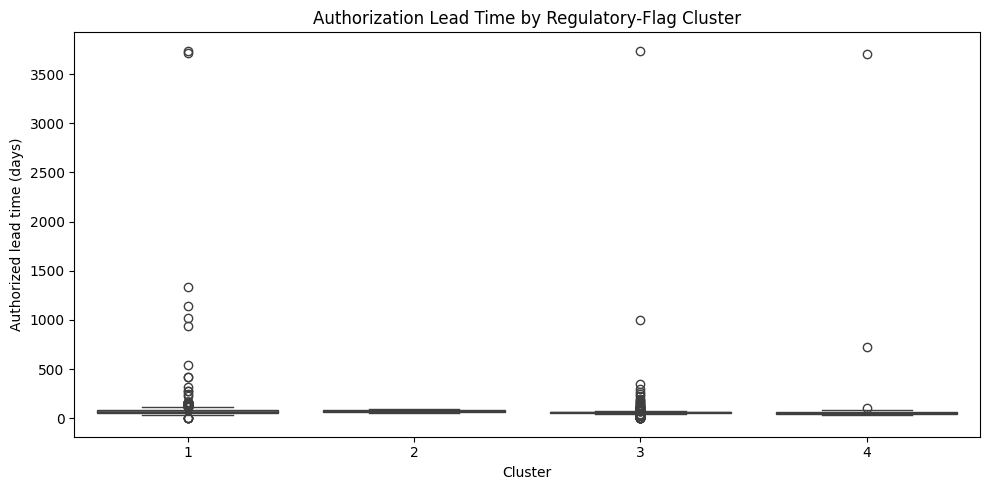

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_time, x='clusters_4', y='authorized_time')
plt.title("Authorization Lead Time by Regulatory-Flag Cluster")
plt.xlabel("Cluster")
plt.ylabel("Authorized lead time (days)")
plt.tight_layout()
plt.show()


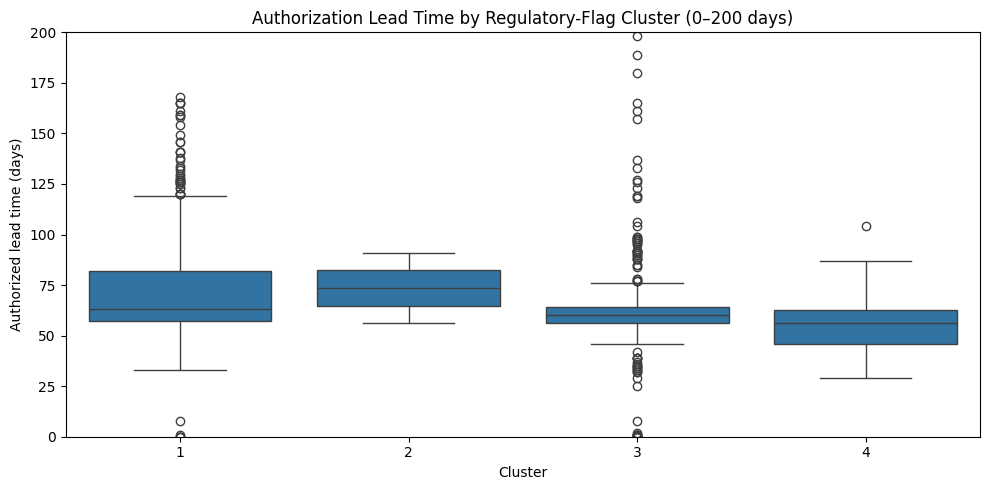

In [32]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_time, x='clusters_4', y='authorized_time')
plt.ylim(0, 200)
plt.title("Authorization Lead Time by Regulatory-Flag Cluster (0–200 days)")
plt.xlabel("Cluster")
plt.ylabel("Authorized lead time (days)")
plt.tight_layout()
plt.show()


Authorization lead time differs across the pathway clusters, both in typical timelines and variability. In the 0–200 day range, Cluster 4 shows the lowest median lead time, followed by Cluster 3 and Cluster 1, while Cluster 2 appears higher but is based on very few observations and should be interpreted cautiously. Beyond median differences, the spread is also informative: the baseline cluster (Cluster 1) shows a broader upper tail, and the monitoring-heavy cluster (Cluster 3) includes many outliers, suggesting that certain pathway contexts are associated with less predictable timelines. Taken together, these patterns support the idea that medicines with different regulatory-flag combinations may face systematically different decision-time dynamics, which matters for expectation-setting and resource planning.

#### **Generic vs. Biosimilar**

In [42]:
df_gb = clustered_4_df[['clusters_4', 'generic', 'biosimilar']].copy()
df_gb = df_gb.replace({True: 1, False: 0})
df_gb[['generic', 'biosimilar']] = df_gb[['generic', 'biosimilar']].apply(pd.to_numeric, errors='coerce')

gb_rate = df_gb.groupby('clusters_4')[['generic', 'biosimilar']].mean()
gb_rate


/tmp/ipython-input-2362959556.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gb = df_gb.replace({True: 1, False: 0})


,generic,biosimilar
clusters_4,,
1,0.207333,0.029333
2,0.000000,0.000000
3,0.009009,0.108108
4,0.000000,0.000000


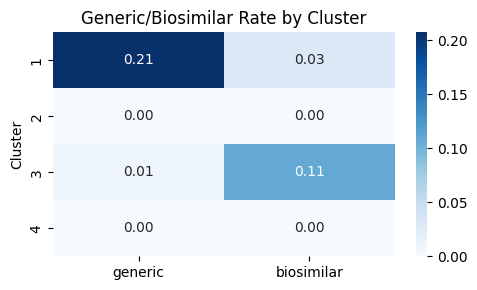

In [43]:
plt.figure(figsize=(5, 3))
sns.heatmap(gb_rate, annot=True, fmt=".2f", cmap="Blues")
plt.title("Generic/Biosimilar Rate by Cluster")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


Product type varies meaningfully across clusters. Cluster 1 has the highest generic share (about 21%), consistent with a baseline pathway that includes more established or follow-on products. In contrast, Cluster 3 shows a noticeably higher biosimilar rate (about 11%) while having very low generic prevalence, suggesting this cluster captures a distinct product and regulatory context. Clusters 2 and 4 have near-zero generic and biosimilar rates in this sample, but these results should be interpreted carefully given the small size of those groups. Overall, the split between Cluster 1 (generic-heavy) and Cluster 3 (biosimilar-enriched) reinforces that the clustering is not only statistically separable but also meaningful for real-world decision making (e.g., pipeline strategy, review prioritization, and planning assumptions)

#### **Therapeutic area**

In [33]:
df_ta = clustered_4_df[['clusters_4', 'therapeutic_area']].dropna().copy()

# split by ';' then explode into one row per therapeutic area
df_ta['therapeutic_area'] = df_ta['therapeutic_area'].str.split(';')
df_ta = df_ta.explode('therapeutic_area')
df_ta['therapeutic_area'] = df_ta['therapeutic_area'].str.strip()

print("Rows after explode:", df_ta.shape[0])
df_ta.head()


Rows after explode: 2942


,clusters_4,therapeutic_area
0,3,"Lymphoma, Non-Hodgkin"
0,3,Hodgkin Disease
1,1,Tyrosinemias
2,3,Lymphoproliferative Disorders
3,3,COVID-19 virus infection


In [34]:
print(df_ta.nunique())

clusters_4            4
therapeutic_area    546
dtype: int64


In [35]:
top_ta = (
    df_ta.groupby(['clusters_4', 'therapeutic_area'])
         .size()
         .reset_index(name='n')
         .sort_values(['clusters_4', 'n'], ascending=[True, False])
)

top5_ta = top_ta.groupby('clusters_4').head(5)
top5_ta


,clusters_4,therapeutic_area,n
102,1,"Diabetes Mellitus, Type 2",73
146,1,HIV Infections,65
174,1,Hypertension,46
180,1,Immunization,43
50,1,Breast Neoplasms,41
402,2,Disease Outbreaks,2
405,2,Immunization,2
406,2,"Influenza, Human",2
403,2,Graft vs Host Disease,1
404,2,Hematopoietic Stem Cell Transplantation,1


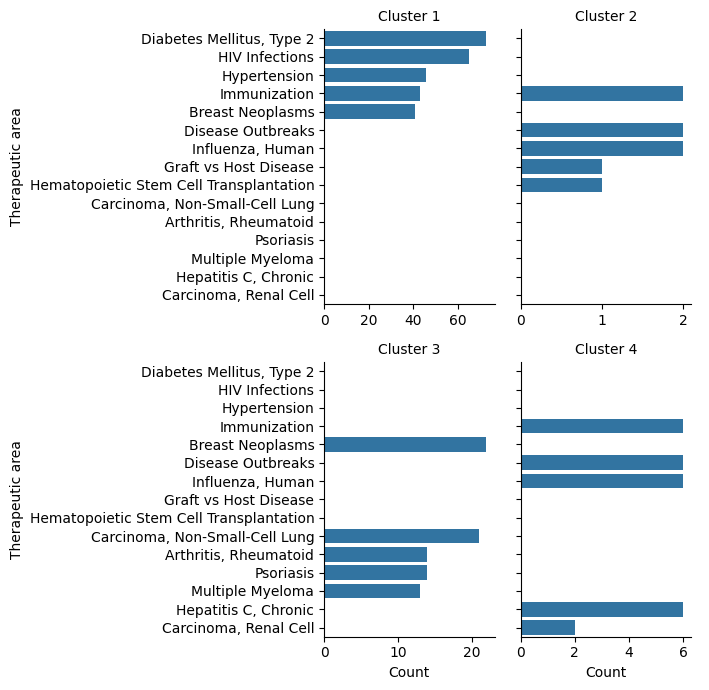

In [36]:
g = sns.catplot(
    data=top5_ta, kind='bar',
    x='n', y='therapeutic_area',
    col='clusters_4', col_wrap=2,
    height=3.5, sharex=False
)
g.set_titles("Cluster {col_name}")
g.set_xlabels("Count")
g.set_ylabels("Therapeutic area")
plt.tight_layout()
plt.show()


Therapeutic areas are not evenly distributed across clusters, which gives some domain context for the pathway segments: the large baseline cluster spans a broad mix of common areas, while the monitoring-heavy cluster shows a different concentration pattern, suggesting certain disease contexts may be more associated with specific regulatory conditions. The smaller clusters appear to repeat a few areas, but because those groups have very few medicines, this chart should be treated as supportive context rather than a definitive difference.

#### **Active Substance**

In [37]:
df_as = clustered_4_df[['clusters_4', 'active_substance']].dropna().copy()

# split by ';' then explode into one row per therapeutic area
df_as['active_substance'] = df_as['active_substance'].str.split(';')
df_as = df_as.explode('active_substance')
df_as['active_substance'] = df_as['active_substance'].str.strip()

print("Rows after explode:", df_as.shape[0])
df_as.head()


Rows after explode: 2002


,clusters_4,active_substance
0,3,brentuximab vedotin
1,1,nitisinone
2,3,tabelecleucel
3,3,"casirivimab, imdevimab"
4,1,secukinumab


In [38]:
print(df_as.nunique())

clusters_4             4
active_substance    1360
dtype: int64


In [39]:
top_as = (
    df_as.groupby(['clusters_4', 'active_substance'])
         .size()
         .reset_index(name='n')
         .sort_values(['clusters_4', 'n'], ascending=[True, False])
)

top5_as = top_as.groupby('clusters_4').head(5)
top5_as


,clusters_4,active_substance,n
584,1,meloxicam,18
488,1,insulin human,12
655,1,olanzapine,12
180,1,clopidogrel,10
708,1,pioglitazone hydrochloride,10
963,2,"split influenza virus, inactivated, containing...",2
962,2,allogeneic t cells genetically modified with a...,1
964,2,vandetanib,1
1232,3,pegfilgrastim,10
973,3,adalimumab,9


/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipython-input-2251446392.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


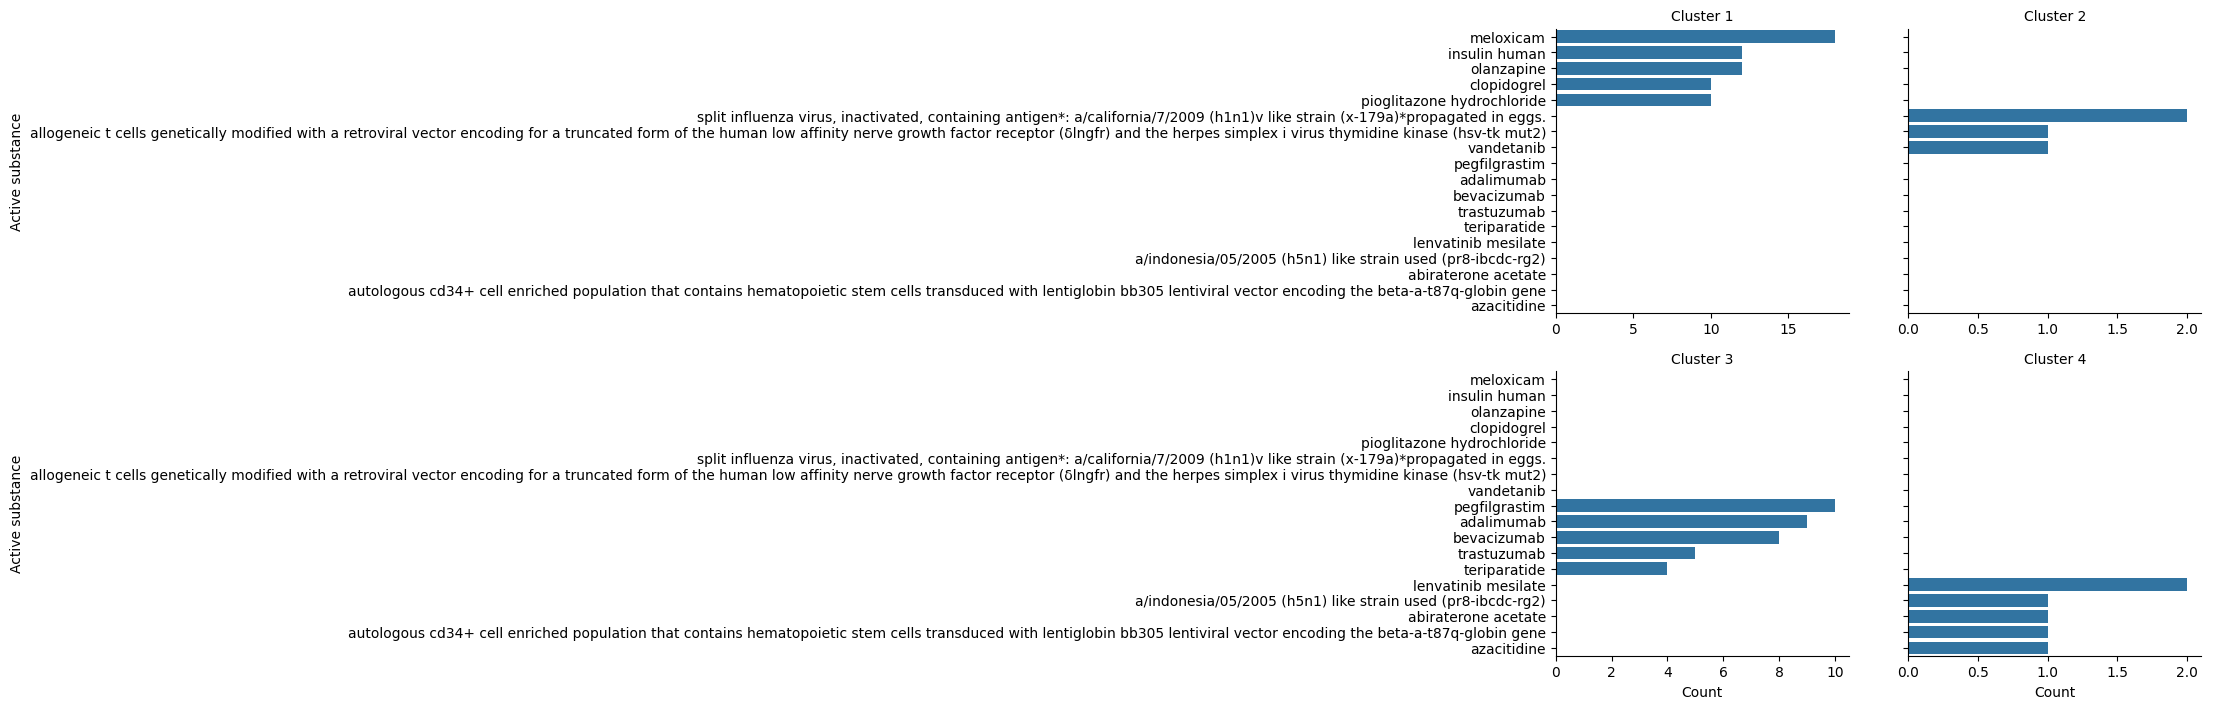

In [40]:
g = sns.catplot(
    data=top5_as, kind='bar',
    x='n', y='active_substance',
    col='clusters_4', col_wrap=2,
    height=3.5, sharex=False
)
g.set_titles("Cluster {col_name}")
g.set_xlabels("Count")
g.set_ylabels("Active substance")
plt.tight_layout()
plt.show()


Active substances show different ‘top examples’ across clusters; however, because active substance is a high-cardinality field and most products appear only once or a few times, I treat this view as illustrative rather than a stable distributional comparison.